Poniższa komórka generuje __losową__ topologię sieci i zapisuje ją do pliku `graph-matrix.txt`.

**Uwaga!** Za każdym razem plik jest całkowicie nadpisywany.


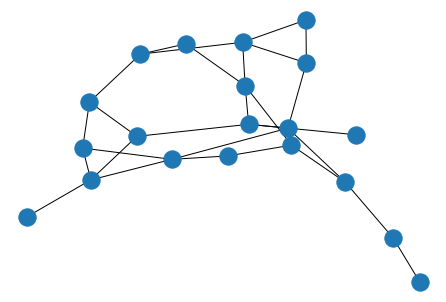

In [284]:
from random import randint
import networkx as nx
import matplotlib.pyplot as plt

G = [[0] * 20 for _ in range(20)]

# generate base edges to ensure every node isn't left alone
for i in range(0, 20):
    j = i
    while j == i:
        j = randint(0, 19)
    G[i][j] = 1

# generate the rest of the edges arbitrarly
for _ in range(9):
    i = randint(0, 19)
    j = randint(0, 19)
    G[i][j] = 1

# copy the edges
for i in range(0, 20):
    for j in range(0, 20):
        if G[i][j] == 1:
            G[j][i] = 1
# clear the unnecessary lower triangle side of the matrix
for i in range(0,20):
    j = 0
    while j < i:
        G[i][j] = 0
        j += 1

G_nx = nx.Graph()
G_nx.add_nodes_from(list(range(0,20)))

for i in range(0,20):
    row = G[i]
    for j in range(0,20):
        if row[j] == 1:
            G_nx.add_edge(i,j)

with open("graph-matrix.txt", "w+") as f:
    for i in range(0,20):
        row = G[i]
        for j in range(0,20):
            f.write(str(row[j]))
        f.write('\n')


nx.draw(G_nx)



Poniższa komórka wyświetla zadaną topologię z pliku w sposób bardziej klarowny.

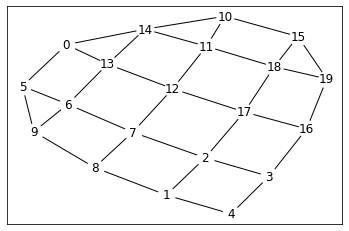

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# read the graph from file
NODES_COUNT = 20
G = []
with open("lattice-matrix.txt", "r") as f:
    line = f.readline()
    while line:
        G.append(
            list(map(
                lambda x: int(x),
                list(line)[:NODES_COUNT]
                )
            ))
        line = f.readline()

G_nx = nx.Graph()
G_nx.add_nodes_from(list(range(0,NODES_COUNT)))

for i in range(0,NODES_COUNT):
    row = G[i]
    for j in range(0,NODES_COUNT):
        if row[j] == 1:
            G_nx.add_edge(i,j)

pos = nx.spring_layout(G_nx)
nx.draw_networkx_nodes(G_nx, pos, node_color="white")
nx.draw_networkx_labels(G_nx, pos)
nx.draw_networkx_edges(G_nx, pos)
plt.show()


Teraz należy przygotować konkretną topologię $G$ jako wejście do programu głównego oraz wygenerować konkretne natężenie sieci $N$.

In [8]:
from random import randint
import networkx as nx
import matplotlib.pyplot as plt
from functools import reduce

# default network packet size
PACKET_SIZE = 2048  # bits
# maximum and minimum packets that can go through a single link
PACKET_COUNT_MAX = 8000
PACKET_COUNT_MIN = 4000

# maximum and minimum throughput of a single link
THROUGHPUT_DEFAULT = 10**9 + 10**8 # 1.1Gbps

NODES_COUNT = 20

# read the graph from file
G = []
with open("lattice-matrix.txt", "r") as f:
    line = f.readline()
    while line:
        G.append(
            list(map(
                lambda x: int(x),
                list(line)[:NODES_COUNT]
                )
            ))
        line = f.readline()



def generate_N():
    """Generates the packet intensity of the network.
    """
    N = [[0] * NODES_COUNT for _ in range(NODES_COUNT)]
    for i in range(0, NODES_COUNT):
        j = i+1
        while j < NODES_COUNT:
            # generate intensity
            N[i][j] = randint(PACKET_COUNT_MIN, PACKET_COUNT_MAX)
            j += 1
    return N

# generate the base N
N = generate_N()


In [19]:
import dijkstar as ds
from random import random
from copy import deepcopy

NODES_COUNT = 20

class NetworkOverload(Exception):
    pass

class ReliabilityMeasure(object):
    """Measure reliability of a network.
    """
    def __init__(self, G):    
        # the starting point of the network 
        self._network_original = G   
        # for testing purposes
        self._G = deepcopy(G)

    def _reset(self):
        self._G = deepcopy(self._network_original)
            
    def _prepare_for_testing(self):
        """Pregenerate some stuff before testing.
        """
        # prepare dijkstar graph for finding shortest path
        self._G_ds = ds.Graph(undirected=True)
        for i in range(0, NODES_COUNT):
            row = self._G[i]
            for j in range(0, NODES_COUNT):
                if row[j] == 1:
                    self._G_ds.add_edge(i, j, 1)
        # render the throughput matrix based on the G
        self._throughput = [[0] * NODES_COUNT for _ in range(NODES_COUNT)]
        for i in range(0, NODES_COUNT):
            for j in range(0, NODES_COUNT):
                if self._G[i][j] == 1:
                    self._throughput[i][j] = THROUGHPUT_DEFAULT
                    self._throughput[j][i] = THROUGHPUT_DEFAULT


    def _generate_flow(self, N):
        """Generates the flow function of the network.
        """
        # render the flow function based on N
        self._flow = [[0] * NODES_COUNT for _ in range(NODES_COUNT)]
        for i in range(0, NODES_COUNT):
            j = i+1
            while j < NODES_COUNT:
                intensity = N[i][j]
                # render it to the flow function
                nodes = ds.find_path(self._G_ds, i, j).nodes
                # loop over the nodes and add the intensity
                # to the edges on the way
                for k in range(0, len(nodes)-1):
                    cur = nodes[k]
                    nex = nodes[k+1]
                    self._flow[cur][nex] += intensity
                    self._flow[nex][cur] += intensity
                    if self._throughput[cur][nex] < self._flow[cur][nex] * PACKET_SIZE:
                        raise NetworkOverload()
                j += 1

    def _calc_avg_packet_latency(self, N):
        T = 0
        for i in range(0, NODES_COUNT):
            j = i+1
            while j < NODES_COUNT:
                if self._G[i][j] == 1:
                    T += self._flow[i][j] / ( (self._throughput[i][j]/PACKET_SIZE) - self._flow[i][j] )
                j += 1
        N_sum = reduce(lambda so_far, curr: so_far+sum(curr), N, 0)
        T /= N_sum
        return T

    
    def measure(self, intensity, edge_probability, T_max):
        """Measures the reliability of this network.

        Args:
            `intensity`: Network packet intensity matrix.
            `edge_probability`: Probability of an edge not to fail.
            `T_max`: Packet latency tolerance.
        """
        successes = 0
        network_overloads = 0
        nopath_errors = 0
        timeouts = 0
        total_count = 500
        # use Monte Carlo algorithm
        for _ in range(0, total_count):
            # tear some edges down
            for i in range(0, NODES_COUNT):
                for j in range(0, NODES_COUNT):
                    # random chance for the edge to die
                    if self._G[i][j] == 1 and random() >= edge_probability:
                        self._G[i][j] = 0

            self._prepare_for_testing()
            # generate the flow function of the network
            try:
                self._generate_flow(intensity)
            except ds.NoPathError:
                # failed - a crucial edge was destroyed
                self._reset()
                nopath_errors += 1
                continue
            except NetworkOverload:
                # failed - too much data for link to send at a time
                network_overloads += 1
                self._reset()
                continue

            T = self._calc_avg_packet_latency(N)
            if T < T_max:
                successes += 1
            else:
                timeouts += 1
            self._reset()

        return successes / total_count, network_overloads, nopath_errors, timeouts

rel = ReliabilityMeasure(G)

result, network_overloads, nopath_errors, timeouts = rel.measure(N, 0.98, 0.0000117)

print("reliability      :", result)
print("network overloads:", network_overloads)
print("nopath errors    :", nopath_errors)
print("timeouts         :", timeouts)


reliability      : 1.0
network overloads: 0
nopath errors    : 0
timeouts         : 0
